The cryptoswap equation given in the Curve whitepaper is

$$ K D^{n-1} \sum_i x_i + \prod_i x_i = K D^n + \left(\frac{D}{n}\right)^n $$

$$ K = A K_0 \frac{\gamma^2}{(\gamma +1 - K_0)^2} $$


$$ K_0 = \frac{\prod x_i n^n}{D^n} $$


The $x_i$'s are the pool balances for each token.

Note $K$ is a function of the balances $x_i$ and $D$.

$D$ is the stableswap invariant.

$A$ is the amplification coefficient.

$\gamma > 0$



In [182]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt


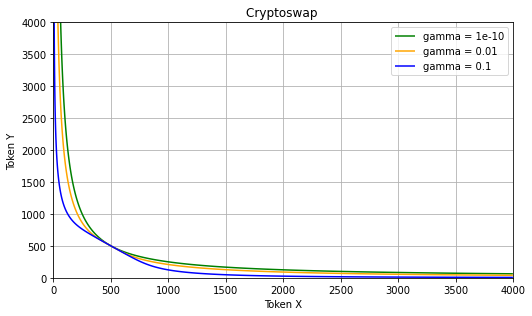

In [188]:
D = 1000
A = 75
n = 2

fig, ax = plt.subplots()
x_end = 4000.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)

gammas = [10**-10, 10**-2, 10**-1]
colors = ['green', 'orange', 'blue']
legend_elements = []
for gamma, color in zip(gammas, colors):
    K0 = x * y* n**n / D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K * D**(n - 1) * (x + y) + x * y - K * D**n - (D / n)**n
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])

labels = [f'gamma = {gamma}' for gamma in gammas]
plt.legend(legend_elements, labels)
plt.show()

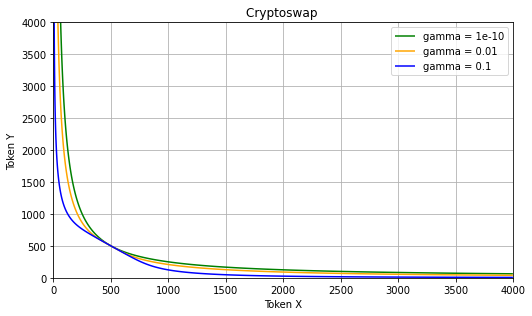

In [189]:
D = 1000
A = 75
n = 2

fig, ax = plt.subplots()
x_end = 4000.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)


gammas = [10**-10, 10**-2, 10**-1]
colors = ['green', 'orange', 'blue']
legend_elements = []
for gamma, color in zip(gammas, colors):
    K0 = x * y* n**n / D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K * D**(n - 1) * (x + y) + x * y - K * D**n - (D / n)**n
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])

labels = [f'gamma = {gamma}' for gamma in gammas]
plt.legend(legend_elements, labels)
plt.show()

In [186]:
MIN_GAMMA = 10**10
MAX_GAMMA = 2 * 10**16
A_MULTIPLIER = 10000

def newton_D(
    ANN,
    gamma,
    x_unsorted,
):
    """
    Finding the `D` invariant using Newton's method.
    """
    n_coins: int = len(x_unsorted)
        
    ANN = int(ANN * A_MULTIPLIER)
    gamma = int(gamma * 10**18)
    
    # Safety checks
    min_A = n_coins**n_coins * A_MULTIPLIER // 10
    max_A = n_coins**n_coins * A_MULTIPLIER * 100000
    assert min_A <= ANN <= max_A, "Unsafe value for A"
    assert MIN_GAMMA <= gamma <= MAX_GAMMA, "Unsafe value for gamma"

    # Initial value of invariant D is that for constant-product invariant
    x = x_unsorted
    if x[0] < x[1]:
        x = [x_unsorted[1], x_unsorted[0]]
        
    assert (
        x[0] > 10**9 - 1 and x[0] < 10**15 * 10**18 + 1
    )  # dev: unsafe values x[0]
    assert x[1] * 10**18 // x[0] > 10**14 - 1  # dev: unsafe values x[i] (input)

    D: int = n_coins * _geometric_mean(x, False)
    S: int = x[0] + x[1]

    for _ in range(255):
        D_prev: int = D

        K0: int = (10**18 * n_coins**2) * x[0] // D * x[1] // D

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = (
            10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // ANN
        )

        # 2*N*K0 / _g1k0
        mul2: int = (2 * 10**18) * n_coins * K0 // _g1k0

        neg_fprime: int = (
            (S + S * mul2 // 10**18) + mul1 * n_coins // K0 - mul2 * D // 10**18
        )

        # D -= f / fprime
        D_plus: int = D * (neg_fprime + S) // neg_fprime
        D_minus: int = D * D // neg_fprime
        if 10**18 > K0:
            D_minus += D * (mul1 // neg_fprime) // 10**18 * (10**18 - K0) // K0
        else:
            D_minus -= D * (mul1 // neg_fprime) // 10**18 * (K0 - 10**18) // K0

        if D_plus > D_minus:
            D = D_plus - D_minus
        else:
            D = (D_minus - D_plus) // 2

        diff = abs(D - D_prev)
        if diff * 10**14 < max(
            10**16, D
        ):  # Could reduce precision for gas efficiency here
            # Test that we are safe with the next newton_y
            for _x in x:
                frac: int = _x * 10**18 // D
                assert 10**16 <= frac <= 10**20, "Unsafe value for x[i]"
            return D // 10**18

    raise Exception("Did not converge")
        
        
        
def _geometric_mean(unsorted_x, sort: bool) -> int:
    """
    (x[0] * x[1] * ...) ** (1/N)
    """
    n_coins: int = len(unsorted_x)
    x = unsorted_x
    if sort and x[0] < x[1]:
        x = [unsorted_x[1], unsorted_x[0]]

    D: int = x[0]
    diff: int = 0
    for _ in range(255):
        D_prev: int = D
        D = (D + x[0] * x[1] // D) // n_coins
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise Exception("Did not converge")

## Price scale repeg

Note: prices assume `y` token is the quote currency.

When the price scale is adjusted ("repegging"), this will lead to a loss for the LP.  This can be seen easily from the below graph.  The cryptoswap curve hugs the constant product curve from below, less tightly in the region of concentrated liquidity.  

Price scale: 1
D: 2077
X_cp: 1038.5
Price scale: 2
D: 2800
X_cp: 989.9494936611666


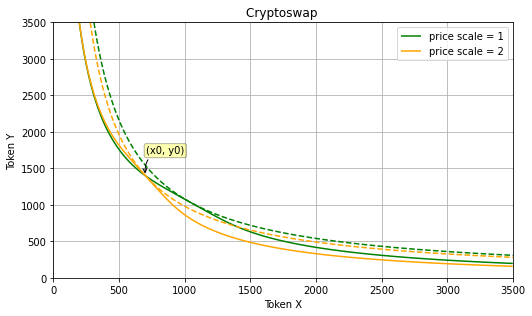

In [190]:
A = 250
n = 2
gamma = 0.01

fig, ax = plt.subplots()
x_end = 3500.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)
# xs = np.linspace(0.0, x_end, num_steps)[1:]

# D = 2100
x0, y0 = 700, 1400

prices = [1, 2]
colors = ['green', 'orange']
legend_elements = []
for p, color in zip(prices, colors):
    print("Price scale:", p)
    Ann = A * n**n
    D = newton_D(Ann, gamma, [p*x0 * 10**18, y0 * 10**18])
    print("D:", D)
    xcp = sqrt((D/2) * D/(2*p))
    print("X_cp:", xcp)
    
    K0 = p*x*y*n**n/D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K*D**(n-1)*(p*x+y) + p*x*y - K*D**n - (D/n)**n
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])
    y_uni = (D**2/(4*p)) / xs
    ax.plot(xs, y_uni, ls='--', color=color, label="constant-product")

plt.legend(loc="upper right")

labels = [f'price scale = {p}' for p in prices]
plt.legend(legend_elements, labels)


ax.annotate('(x0, y0)', xy=(x0, y0), xytext=(20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='black'))

plt.show()